# Classification using the MNIST dataset

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]

In [3]:
X.shape # data

(70000, 784)

In [4]:
y.shape # target

(70000,)

In [5]:
mnist['data'].shape

(70000, 784)

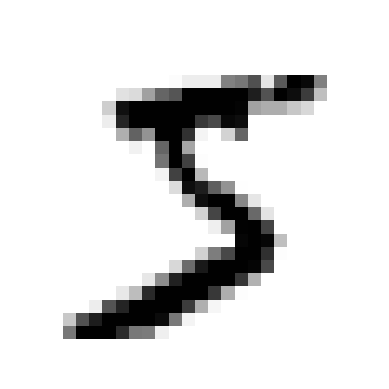

In [6]:
# let's see one of the image! convert data
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [7]:
# looks a five! let's check
y[0]

'5'

In [8]:
# and is a string.
# to convert
import numpy as np

y = y.astype(np.uint8)

The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images)

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Let's try a binary classifier, with two classes: 5 and not 5.

In [10]:
# Target vectors for this classification task
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

### SGD Stochastic Gradient Descent
Let's start with the Stochastic Gradient Descent (SGD) classifier

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
# Now we can use it to detect images of the number 5

sgd_clf.predict([some_digit]) # some digit X[0], it is a 5.

array([ True])

### Measuring Accuracy Using Cross-Validation

In [13]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, scoring="accuracy", cv = 3)

array([0.95035, 0.96035, 0.9604 ])

In [14]:
# quite high! but accuracy is not a good indicator in case of a not homogeneous dataset (we are classifying 5 or not 5!)
# a much better indicator is the confusion matrix!

### Confusion matrix

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold.

In [16]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [17]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

## Precision and recall

precision = TP/(TP+FP)
True Positive and False Positive

Recall or Sensitivity or True positive ratio = TP/(TP + FN)
True Positive and False Negative

In [52]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)
# the number of time 5 is classified correctly

0.8370879772350012

In [19]:
# the number of 5 detected
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [20]:
# The F score is the harmonic mean of precision and recall
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [21]:
y_scores = sgd_clf.decision_function([some_digit])


In [22]:
y_scores


array([2164.22030239])

In [23]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [24]:
# clear, with threshold of 0, it detect a 5. let s rise above what we found
threshold = 4000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

How do you decide which threshold to use? First, use the cross_val_predict() function to get the scores of all instances in the training set, but this time specify that you want to return decision scores instead of predictions

In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [26]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, -0.2, 1.2])

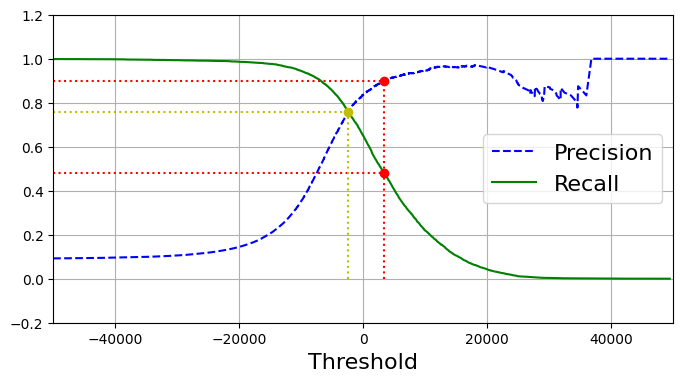

In [28]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

recall_equal_precision = recalls[np.argmax(precisions == recalls)]
threshold_equal_precision = thresholds[np.argmax(precisions == recalls)]

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")

plt.plot([threshold_equal_precision, threshold_equal_precision], [0., recall_equal_precision], "y:")
plt.plot([-50000, threshold_equal_precision], [recall_equal_precision, recall_equal_precision], "y:")
plt.plot([threshold_equal_precision], [recall_equal_precision], "yo")

plt.show()

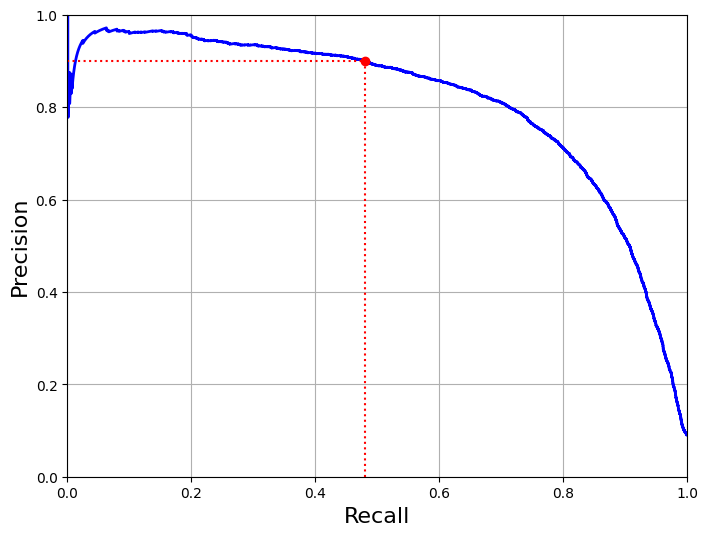

In [29]:
# Another way to select a good precision/recall trade-off is to plot precision directly against recall

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [30]:
recall_equal_precision

0.7572403615569083

In [31]:
threshold_equal_precision

-2379.064500932274

## ROC curve
The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers

true positive rate (another name for recall) against the false positive rate (FPR).
The FPR is the ratio of negative instances that are incorrectly classified as positive.

In [32]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

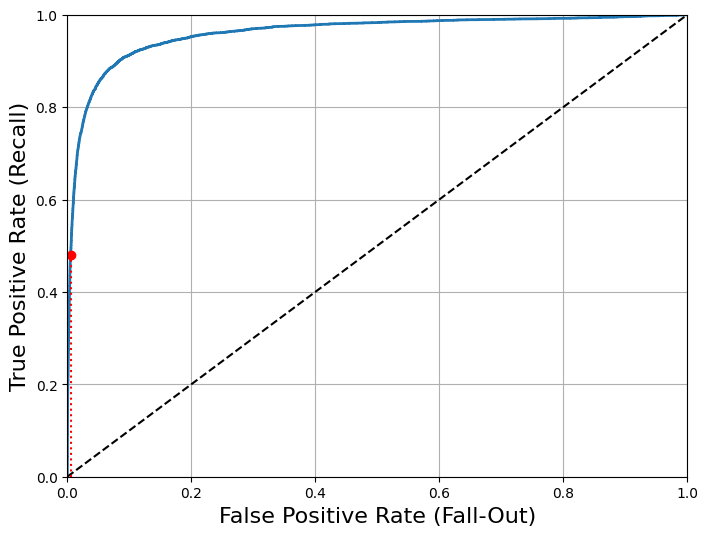

In [34]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.show()


To compare classifiers is to measure the area under the curve (AUC). 
A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5

In [35]:
# to calculate the ROC AUC
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

## ROC vs PR curve
Use the PR when you care more about false positive (and positive are rare)
otherwise the ROC.

## RandomForestClassifier

Let's train and compare with RandomForestClassifier

The RandomForestClassifier do not provide the decision_function() but instead it has the predict_proba() method.
The predict_proba() method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class

In [36]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [42]:
y_scores_forest = y_probas_forest[:, 1]

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

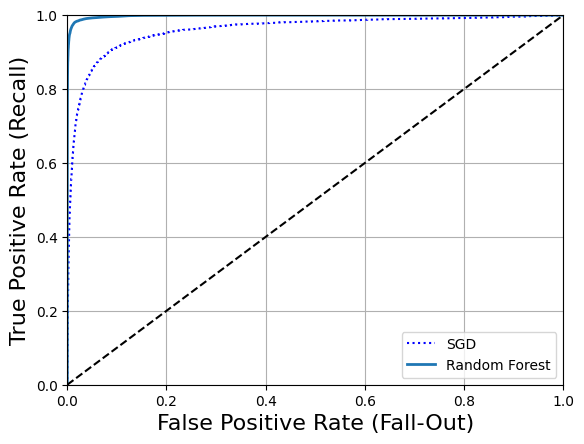

In [43]:
# let's plot the roc of the random forest against the the SGD

plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc = "lower right")
plt.show()

In [45]:
# and the roc auc of the random forest ...

roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [50]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [51]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

## Multiclass Classification

OvO vs OvR

In [ ]:
# Let’s bergin with a Support Vector Machine classifier

In [55]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train) # go back to all dataset


SVC()

In [58]:
prediction = svm_clf.predict([some_digit])

In [59]:
prediction

array([5], dtype=uint8)

In [62]:
# Let's check the decision function to see the output

some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In this case OvO is automatically used by scikit learn.
Let's try to force the use of OvR

To force OvO or OvR you can use OneVsRestClassifier or OneVsOneClassifier

In [64]:
# OvR instance for SVC
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [65]:
len(ovr_clf.estimators_)

10

## SGDClassifier for multi class

In [72]:
sgd_clf.fit(X_train, y_train) # using the previous istance of SGD
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [73]:
# Let's check the decision_function() and what returns
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [74]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [75]:
#### apply Standardization ... and re check

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error analysis 

In [76]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

In [77]:
# nice! but have it in a displayed matrix

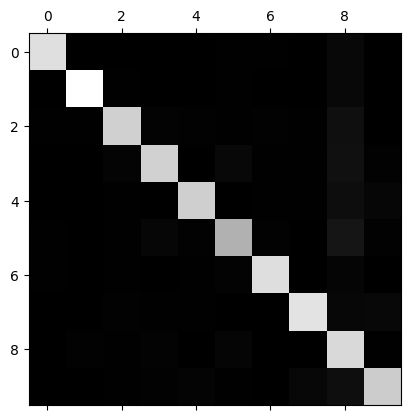

In [78]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

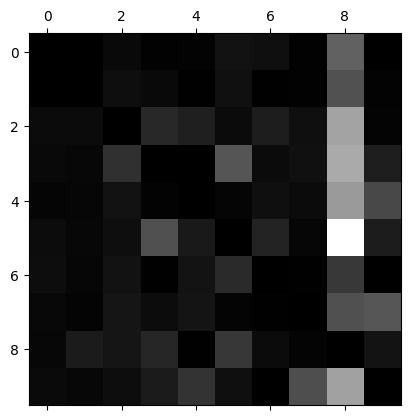

In [79]:
# and let s focus on the error.

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [80]:
# bad: 8 in general, and 3 vs 5.

### Multilabel Classification

In [84]:
# an example, with 2 class:
# if number greater or equal of 7 and is odd

from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [85]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [86]:
# ook 5 is not big but it is odd.

## Multioutput Classification